# Construíndo o modelo de regressão logística

#### Todos os pacotes que usaremos nesta terceira parte (regressão logística)

In [113]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
import scikitplot as skplt

from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import binarize

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

In [114]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [115]:
df.rename(columns={'id':'ID', 'gender': 'Gênero', 'age': 'Idade', 'hypertension':'Hipertensão', 'heart_disease':'Doença cardíaca',
                   'ever_married':'Já casou','work_type':'Tipo de trabalho','Residence_type':'Tipo de residência',
                   'avg_glucose_level':'Nível médio de glicose','bmi':'IMC','smoking_status':'Tabagismo','stroke':'Derrame'}, inplace=True)

In [116]:
df.head()

,ID,Gênero,Idade,Hipertensão,Doença cardíaca,Já casou,Tipo de trabalho,Tipo de residência,Nível médio de glicose,IMC,Tabagismo,Derrame
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [117]:
df["Gênero"] = df["Gênero"].str.replace("Male","Masculino")
df["Gênero"] = df["Gênero"].str.replace("Female","Feminino")
df["Gênero"] = df["Gênero"].str.replace("Other","Outro")

In [118]:
df["Já casou"] = df["Já casou"].str.replace("Yes","Sim")
df["Já casou"] = df["Já casou"].str.replace("No","Não")

In [119]:
df["Tipo de trabalho"] = df["Tipo de trabalho"].str.replace("children","Criança")
df["Tipo de trabalho"] = df["Tipo de trabalho"].str.replace("Govt_job","Serv_publi")
df["Tipo de trabalho"] = df["Tipo de trabalho"].str.replace("Never_worked","Nunca_trab")
df["Tipo de trabalho"] = df["Tipo de trabalho"].str.replace("Private","Privado")
df["Tipo de trabalho"] = df["Tipo de trabalho"].str.replace("Self-employed","Autônomo")

In [120]:
df["Tipo de residência"] = df["Tipo de residência"].str.replace("Urban","Urbana")

In [121]:
df["Tabagismo"] = df["Tabagismo"].str.replace("formerly smoked","Já fumou")
df["Tabagismo"] = df["Tabagismo"].str.replace("never smoked","Nunca fumou")
df["Tabagismo"] = df["Tabagismo"].str.replace("smokes","Fuma")
df["Tabagismo"] = df["Tabagismo"].str.replace("Unknown","Desconhecido")

In [122]:
df.head(6)

,ID,Gênero,Idade,Hipertensão,Doença cardíaca,Já casou,Tipo de trabalho,Tipo de residência,Nível médio de glicose,IMC,Tabagismo,Derrame
0,9046,Masculino,67.0,0,1,Sim,Privado,Urbana,228.69,36.6,Já fumou,1
1,51676,Feminino,61.0,0,0,Sim,Autônomo,Rural,202.21,NaN,Nunca fumou,1
2,31112,Masculino,80.0,0,1,Sim,Privado,Rural,105.92,32.5,Nunca fumou,1
3,60182,Feminino,49.0,0,0,Sim,Privado,Urbana,171.23,34.4,Fuma,1
4,1665,Feminino,79.0,1,0,Sim,Autônomo,Rural,174.12,24.0,Nunca fumou,1
5,56669,Masculino,81.0,0,0,Sim,Privado,Urbana,186.21,29.0,Já fumou,1


Dados Faltantes

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      5110 non-null   int64  
 1   Gênero                  5110 non-null   object 
 2   Idade                   5110 non-null   float64
 3   Hipertensão             5110 non-null   int64  
 4   Doença cardíaca         5110 non-null   int64  
 5   Já casou                5110 non-null   object 
 6   Tipo de trabalho        5110 non-null   object 
 7   Tipo de residência      5110 non-null   object 
 8   Nível médio de glicose  5110 non-null   float64
 9   IMC                     4909 non-null   float64
 10  Tabagismo               5110 non-null   object 
 11  Derrame                 5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [124]:
DT_IMC_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X1 = df[['Idade','Gênero','IMC','Nível médio de glicose']].copy()
X1['Gênero'] = X1['Gênero'].replace({'Masculino':0,'Feminino':1,'Outro':-1}).astype(np.uint8)

Missing = X1[X1['IMC'].isna()]
X1 = X1[~X1['IMC'].isna()]
Y1 = X1.pop('IMC')
DT_IMC_pipe.fit(X1,Y1)
#Usando vairáveis relacionadas com IMC para prevelo, 'Idade','Gênero','Nível médio de glicose'
predicted_IMC = pd.Series(DT_IMC_pipe.predict(Missing[['Idade','Gênero','Nível médio de glicose']]),index=Missing.index)
df.loc[Missing.index,'IMC'] = predicted_IMC

### Criando X, que terá as variáveis que utilizaremos, e y, que terá a variável preditora

In [125]:
X = df.drop(['ID','Derrame'],axis=1)
y = df['Derrame']

In [126]:
X.head()

,Gênero,Idade,Hipertensão,Doença cardíaca,Já casou,Tipo de trabalho,Tipo de residência,Nível médio de glicose,IMC,Tabagismo
0,Masculino,67.0,0,1,Sim,Privado,Urbana,228.69,36.6,Já fumou
1,Feminino,61.0,0,0,Sim,Autônomo,Rural,202.21,45.0,Nunca fumou
2,Masculino,80.0,0,1,Sim,Privado,Rural,105.92,32.5,Nunca fumou
3,Feminino,49.0,0,0,Sim,Privado,Urbana,171.23,34.4,Fuma
4,Feminino,79.0,1,0,Sim,Autônomo,Rural,174.12,24.0,Nunca fumou


### Usando o one hot enconding

In [127]:
X['Já casou'] = X['Já casou'].replace({'Não':0,'Sim':1}).astype(np.uint8)### Usando o one hot enconding
X = pd.get_dummies(X, columns = ['Tipo de trabalho','Tabagismo','Gênero','Tipo de residência'])

In [128]:
X.head()

,Idade,Hipertensão,Doença cardíaca,Já casou,Nível médio de glicose,IMC,Tipo de trabalho_Autônomo,Tipo de trabalho_Criança,Tipo de trabalho_Nunca_trab,Tipo de trabalho_Privado,Tipo de trabalho_Serv_publi,Tabagismo_Desconhecido,Tabagismo_Fuma,Tabagismo_Já fumou,Tabagismo_Nunca fumou,Gênero_Feminino,Gênero_Masculino,Gênero_Outro,Tipo de residência_Rural,Tipo de residência_Urbana
0,67.0,0,1,1,228.69,36.6,0,0,0,1,0,0,0,1,0,0,1,0,0,1
1,61.0,0,0,1,202.21,45.0,1,0,0,0,0,0,0,0,1,1,0,0,1,0
2,80.0,0,1,1,105.92,32.5,0,0,0,1,0,0,0,0,1,0,1,0,1,0
3,49.0,0,0,1,171.23,34.4,0,0,0,1,0,0,1,0,0,1,0,0,0,1
4,79.0,1,0,1,174.12,24.0,1,0,0,0,0,0,0,0,1,1,0,0,1,0


### Criando o dataframe "base" para o K-fold

In [129]:
base = df.drop(['ID'],axis=1)
base['Já casou'] = base['Já casou'].replace({'Não':0,'Sim':1}).astype(np.uint8)
base = pd.get_dummies(base, columns = ['Tipo de trabalho','Tabagismo','Gênero','Tipo de residência'])

## Usaremos o método de Oversampling para a regressão logística

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])

In [131]:
ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

In [132]:
logreg_pipeline.fit(X_train,y_train)

pred_logreg = logreg_pipeline.predict(X_test)

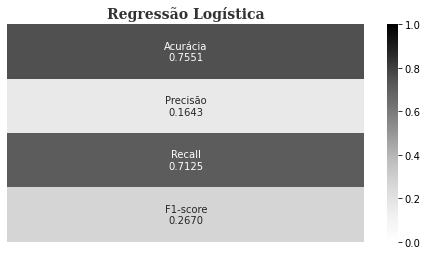

In [133]:
fig = plt.figure(figsize=(8,4))
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.1, hspace=0.25)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#ffffff"
fig.patch.set_facecolor(background_color)

scores_names = np.array(['Acurácia','Precisão',
                     'Recall','F1-score'])

logreg_scores = np.array([accuracy_score(y_test,pred_logreg),precision_score(y_test,pred_logreg),
                     recall_score(y_test,pred_logreg),f1_score(y_test,pred_logreg)])

group_scores = ['{:.4f}'.format(value) for value in
                logreg_scores]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(scores_names,group_scores)]
labels = np.asarray(labels).reshape(4,1)
logreg_scores = np.asarray(logreg_scores).reshape(4,1)

sns.heatmap(logreg_scores, annot=labels, fmt='', cmap='Greys',ax=ax0,xticklabels=False,yticklabels=False,vmin=0, vmax=1)
ax0.tick_params(left=False, bottom=False)
ax0.set_title('Regressão Logística',loc='center', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

plt.show()

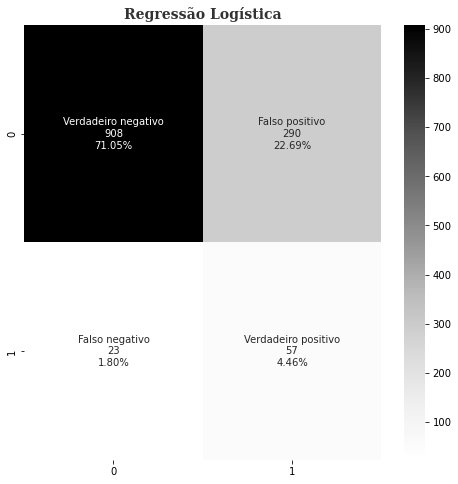

In [134]:
cm_rl = confusion_matrix(y_test, pred_logreg)

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.15, hspace=0.15)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#ffffff"
fig.patch.set_facecolor(background_color) # figure background color

group_names = ['Verdadeiro negativo','Falso positivo','Falso negativo','Verdadeiro positivo']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_rl.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_rl.flatten()/np.sum(cm_rl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_rl, annot=labels, fmt='', cmap='Greys',ax=ax0)

ax0.set_title('Regressão Logística',loc='center', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

plt.show()

### Função para fazer o K-fold manualmente

In [135]:
def kfold(base, k = 5):
    '''Essa função retorna, de acordo com a base e o k, os indexes aleatórios para cada partição k.'''
    list_indexes = [] # Lista com os indexes para cada partição. 
    obs_in_each_partition = int(np.round(base.shape[0]/k)) # quantas observações em cada partição
    
    possible_indexes = base.index.values # lista de indexes da base possíveis
    for k_zin in range(1, k):
        new_list_index = np.random.choice(possible_indexes, obs_in_each_partition, replace = False) #escolhendo as obs para o k
        possible_indexes = set(possible_indexes) - set(new_list_index) #tirando as obs do k atual, da lista de indexes possíveis
        possible_indexes = list(possible_indexes) 
        list_indexes.append(new_list_index) # adicionando as obs do k atual, na lista com os indexes para cada partição.
    
    list_indexes.append(np.array(possible_indexes)) # adicionando as obs da última partição (normalmente com menor size)
    return list_indexes   

## Fazendo um gridsearch manual

In [136]:
import warnings
warnings.filterwarnings('ignore')

In [137]:
#Melhor resultado ['0.004772' 'l1' '0.85805468949655' '0.21974044873510098']
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.004772,penalty='l1',
                                                                                        solver= 'liblinear',random_state=42))])
"""
ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

re_max,f1_max=0,0
recall_max = np.zeros((5,1))
f1score_max = np.zeros((5,1))
for i in np.logspace(-3, 3, 1000):
    for j in ['l1','l2']:
        logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),
                                            ('LR',LogisticRegression(C=i,penalty=j,
                                                                     solver= 'liblinear',random_state=42))])
        c = -1
        for k in kfold(base):
            # dividindo a base
            base_val = base.iloc[k]
            indexes_train = base.index.difference(base_val.index)
            base_treino = base.iloc[indexes_train] 

            # dividindo em X e y
            X_train, y_train = base_treino.drop(['Derrame'], 1), base_treino.Derrame
            X_train, y_train = ros.fit_resample(X_train, y_train)
            X_val, y_val = base_val.drop(['Derrame'], 1), base_val.Derrame

            # fazendo o modelo
            model_rl = logreg_pipeline.fit(X_train, y_train)

            # predizendo na base de validação normalizada
            pred_logreg = model_rl.predict(X_val)

            # alocando o f1_score do k atual, na lista de perforamnce
            c = c + 1 
            recall_max[c], f1score_max[c] = recall_score(y_val, pred_logreg),f1_score(y_val, pred_logreg)
        recall_mean, f1_mean = recall_max.sum()/5, f1score_max.sum()/5
        if (recall_mean >= re_max) and (f1_mean >= f1_max):
            re_max,f1_max=recall_mean,f1_mean
            print(np.array([round(i,6),j,re_max,f1_max]))
"""

"\nros = RandomOverSampler(random_state=42)\n\nX_train, y_train = ros.fit_resample(X_train, y_train)\n\nre_max,f1_max=0,0\nrecall_max = np.zeros((5,1))\nf1score_max = np.zeros((5,1))\nfor i in np.logspace(-3, 3, 1000):\n    for j in ['l1','l2']:\n        logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),\n                                            ('LR',LogisticRegression(C=i,penalty=j,\n                                                                     solver= 'liblinear',random_state=42))])\n        c = -1\n        for k in kfold(base):\n            # dividindo a base\n            base_val = base.iloc[k]\n            indexes_train = base.index.difference(base_val.index)\n            base_treino = base.iloc[indexes_train] \n\n            # dividindo em X e y\n            X_train, y_train = base_treino.drop(['Derrame'], 1), base_treino.Derrame\n            X_train, y_train = ros.fit_resample(X_train, y_train)\n            X_val, y_val = base_val.drop(['Derrame'], 1), ba

### Observando os pesos das variáveis para o modelo encontrado

#### Pesos do modelo default

In [138]:
#O modelo default tem c=1
X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(X, y, test_size=0.25, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_def, y_train_def = ros.fit_resample(X_train_def, y_train_def)

logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])
logreg_pipeline.fit(X_train_def, y_train_def)
logreg_tuned_pred = logreg_pipeline.predict(X_test_def)
pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(logreg_pipeline.named_steps['LR'].coef_))], axis = 1)

,0,0
0,Idade,1.841204
1,Hipertensão,0.278045
2,Doença cardíaca,0.100287
3,Já casou,-0.091268
4,Nível médio de glicose,0.223734
5,IMC,-0.066866
6,Tipo de trabalho_Autônomo,-0.127198
7,Tipo de trabalho_Criança,0.393608
8,Tipo de trabalho_Nunca_trab,-0.210370
9,Tipo de trabalho_Privado,-0.030774


#### Pesos do modelo ótimo com relação ao recall e f1-score

In [139]:
X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(X, y, test_size=0.25, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_def, y_train_def = ros.fit_resample(X_train_def, y_train_def)

logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.004772,penalty='l1',
                                                                                        solver= 'liblinear',random_state=42))])
logreg_pipeline.fit(X_train_def, y_train_def)
logreg_tuned_pred = logreg_pipeline.predict(X_test_def)
pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(logreg_pipeline.named_steps['LR'].coef_))], axis = 1).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Idade,Hipertensão,Doença cardíaca,Já casou,Nível médio de glicose,IMC,Tipo de trabalho_Autônomo,Tipo de trabalho_Criança,Tipo de trabalho_Nunca_trab,Tipo de trabalho_Privado,Tipo de trabalho_Serv_publi,Tabagismo_Desconhecido,Tabagismo_Fuma,Tabagismo_Já fumou,Tabagismo_Nunca fumou,Gênero_Feminino,Gênero_Masculino,Gênero_Outro,Tipo de residência_Rural,Tipo de residência_Urbana
0,1.317552,0.121021,0.038613,0.0,0.095486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Gráfico da variação das medidas e dos pesos das variáveis dependendo do valor do parametro de penalidade

In [140]:
X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(X, y, test_size=0.25, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_def, y_train_def = ros.fit_resample(X_train_def, y_train_def)

acu = np.zeros((5,1000))
pre = np.zeros((5,1000))
rec = np.zeros((5,1000))
f1 = np.zeros((5,1000))
coefficients = np.zeros((20,1000))
c1 = -1
c2 = -1
re_max,f1_max=0,0
recall_max = np.zeros((5,1))
f1score_max = np.zeros((5,1))
for i in np.logspace(-3, 3, 1000):
    logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=i,penalty='l1',
                                                                                        solver= 'liblinear',random_state=42))])
    c1 = -1
    c2 = c2 + 1
    if ((c2+1) % 50) == 0:
        print(c2)
    for k in kfold(base):
        # dividindo a base
        base_val = base.iloc[k]
        indexes_train = base.index.difference(base_val.index)
        base_treino = base.iloc[indexes_train] 

        # dividindo em X e y
        X_train, y_train = base_treino.drop(['Derrame'], 1), base_treino.Derrame
        X_train, y_train = ros.fit_resample(X_train, y_train)
        X_val, y_val = base_val.drop(['Derrame'], 1), base_val.Derrame

        # fazendo o modelo
        model_rl = logreg_pipeline.fit(X_train, y_train)

        # predizendo na base de validação normalizada
        y_pred_rl = model_rl.predict(X_val)

        # alocando o f1_score do k atual, na lista de perforamnce
        c1 = c1 + 1 
        acu[c1,c2] = accuracy_score(y_val,y_pred_rl)
        pre[c1,c2] = precision_score(y_val,y_pred_rl)
        rec[c1,c2] = recall_score(y_val,y_pred_rl)
        f1[c1,c2] = f1_score(y_val,y_pred_rl)
    logreg_pipeline.fit(X_train_def, y_train_def)
    coefficients[:,c2] = np.transpose(logreg_pipeline.named_steps['LR'].coef_[0])


49
99
149
199
249
299
349
399
449
499
549
599
649
699
749
799
849
899
949
999


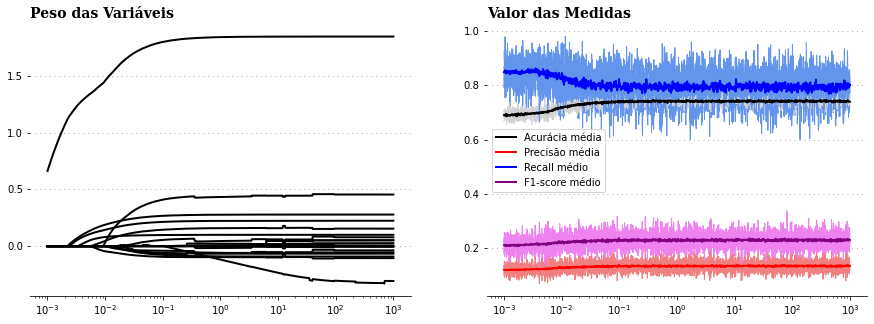

In [141]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1,2, wspace=0.2,hspace=0)
ax = gs.subplots()

background_color = "#ffffff"
fig.patch.set_facecolor(background_color) # figure background color
ax[0].set_facecolor(background_color) 
ax[1].set_facecolor(background_color)

ax[0].grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax[1].grid(color='gray', linestyle=':', axis='y',  dashes=(1,5))

labels = np.array(['Acurácia média','Precisão média','Recall médio','F1-score médio'])
colors1 = np.array(['black','red','blue','purple'])
colors2 = np.array(['lightgray','lightcoral','cornflowerblue','violet'])
for i in range(0,20):
    ax[0].plot(np.logspace(-3, 3, 1000), coefficients[i,:], linewidth=2,color='#000000')
    
for i in range(0,5):
    ax[1].plot(np.logspace(-3, 3, 1000), acu[i,:],
               linewidth=1,color=colors2[0])
    ax[1].plot(np.logspace(-3, 3, 1000), pre[i,:],
               linewidth=1,color=colors2[1])
    ax[1].plot(np.logspace(-3, 3, 1000), rec[i,:],
               linewidth=1,color=colors2[2])
    ax[1].plot(np.logspace(-3, 3, 1000), f1[i,:],
               linewidth=1,color=colors2[3])

ax[1].plot(np.logspace(-3, 3, 1000), acu.mean(axis=0),
            linewidth=2, label=labels[0],color=colors1[0])
ax[1].plot(np.logspace(-3, 3, 1000), pre.mean(axis=0),
            linewidth=2, label=labels[1],color=colors1[1])
ax[1].plot(np.logspace(-3, 3, 1000), rec.mean(axis=0),
            linewidth=2, label=labels[2],color=colors1[2])
ax[1].plot(np.logspace(-3, 3, 1000), f1.mean(axis=0),
               linewidth=2, label=labels[3],color=colors1[3])
    
ax[1].legend(loc='best')
    
for s in ["top","right","left"]:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_title('Peso das Variáveis',loc='left',fontsize=14,fontfamily='serif',fontweight='bold')
ax[1].set_title('Valor das Medidas',loc='left',fontsize=14,fontfamily='serif',fontweight='bold')


plt.show()

### Comparando o modelo encontrado no gridsearch com o default

In [142]:
X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(X, y, test_size=0.25, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_def, y_train_def = ros.fit_resample(X_train_def, y_train_def)

logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])
logreg_pipeline.fit(X_train_def, y_train_def)
logreg_tuned_pred = logreg_pipeline.predict(X_test_def)

print(np.array([accuracy_score(y_test_def, logreg_tuned_pred),precision_score(y_test_def, logreg_tuned_pred),
                     recall_score(y_test_def, logreg_tuned_pred),f1_score(y_test_def, logreg_tuned_pred)]))

logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.004772,penalty='l1',
                                                                                        solver= 'liblinear',random_state=42))])
logreg_pipeline.fit(X_train_def, y_train_def)
logreg_tuned_pred = logreg_pipeline.predict(X_test_def)

print(np.array([accuracy_score(y_test_def, logreg_tuned_pred),precision_score(y_test_def, logreg_tuned_pred),
                     recall_score(y_test_def, logreg_tuned_pred),f1_score(y_test_def, logreg_tuned_pred)]))

[0.75508607 0.16426513 0.7125     0.26697892]
[0.71361502 0.15625    0.8125     0.26209677]


### Plots das métricas do modelo encontrado

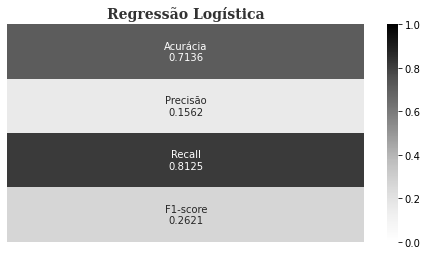

In [143]:
fig = plt.figure(figsize=(8,4))
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.1, hspace=0.25)
ax1 = fig.add_subplot(gs[0, 0])

background_color = "#ffffff"
fig.patch.set_facecolor(background_color)

scores_names = np.array(['Acurácia','Precisão',
                     'Recall','F1-score'])

logreg_scores = np.array([accuracy_score(y_test_def,logreg_tuned_pred),precision_score(y_test_def,logreg_tuned_pred),
                     recall_score(y_test_def,logreg_tuned_pred),f1_score(y_test_def,logreg_tuned_pred)])

group_scores = ['{:.4f}'.format(value) for value in
                logreg_scores]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(scores_names,group_scores)]
labels = np.asarray(labels).reshape(4,1)
logreg_scores = np.asarray(logreg_scores).reshape(4,1)

sns.heatmap(logreg_scores, annot=labels, fmt='', cmap='Greys',ax=ax1,xticklabels=False,yticklabels=False,vmin=0, vmax=1)
ax1.tick_params(left=False, bottom=False)
ax1.set_title('Regressão Logística',loc='center', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

plt.show()

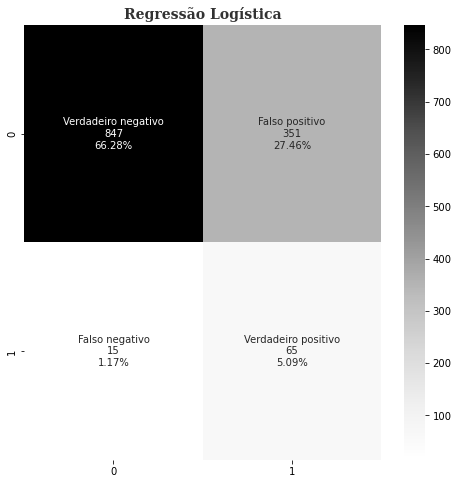

In [144]:
cm_rl = confusion_matrix(y_test_def, logreg_tuned_pred)

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.15, hspace=0.15)
ax1 = fig.add_subplot(gs[0, 0])

background_color = "#ffffff"
fig.patch.set_facecolor(background_color) # figure background color

group_names = ['Verdadeiro negativo','Falso positivo','Falso negativo','Verdadeiro positivo']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_rl.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_rl.flatten()/np.sum(cm_rl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_rl, annot=labels, fmt='', cmap='Greys',ax=ax1)

ax1.set_title('Regressão Logística',loc='center', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

plt.show()

## Tunando o Threshold

### Observando os resultados de diferentes thresholds

In [145]:
for i in range(200,501):
    
    cm1=0
    y_pred1 = logreg_pipeline.predict_proba(X_test_def)[:,1]
    y_pred1 = y_pred1.reshape(-1,1)
    y_pred2 = binarize(y_pred1, threshold = i/1000)
    y_pred2 = np.where(y_pred2 == 1, 1, 0)
    cm1 = confusion_matrix(y_test_def, y_pred2)
        
    print ('Para',i/1000,'de threshold a matriz de confusão é','\n\n',cm1,'\n\n',
            'Com',cm1[0,0]+cm1[1,1],'predições corretas, ', '\n\n', 
           
            cm1[0,1],'Erros tipo I (Falsos Positivos), ','\n\n',
           
            cm1[1,0],'Erros tipo II (Falsos Negativos), ','\n\n',
           
           'Acurácia: ', (accuracy_score(y_test_def, y_pred2)), '\n\n',
           'F1-score: ', (f1_score(y_test_def, y_pred2)), '\n\n',
           'Sensibilidade: ',cm1[1,1]/(float(cm1[1,1]+cm1[1,0])), '\n\n',
           
           'Especificidade: ',cm1[0,0]/(float(cm1[0,0]+cm1[0,1])),'\n\n',
          
            '====================================================', '\n\n')

Para 0.2 de threshold a matriz de confusão é 

 [[457 741]
 [  0  80]] 

 Com 537 predições corretas,  

 741 Erros tipo I (Falsos Positivos),  

 0 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.42018779342723006 

 F1-score:  0.17758046614872364 

 Sensibilidade:  1.0 

 Especificidade:  0.3814691151919866 



Para 0.201 de threshold a matriz de confusão é 

 [[458 740]
 [  0  80]] 

 Com 538 predições corretas,  

 740 Erros tipo I (Falsos Positivos),  

 0 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.4209702660406886 

 F1-score:  0.17777777777777776 

 Sensibilidade:  1.0 

 Especificidade:  0.3823038397328882 



Para 0.202 de threshold a matriz de confusão é 

 [[458 740]
 [  0  80]] 

 Com 538 predições corretas,  

 740 Erros tipo I (Falsos Positivos),  

 0 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.4209702660406886 

 F1-score:  0.17777777777777776 

 Sensibilidade:  1.0 

 Especificidade:  0.3823038397328882 



Para 0.203 de threshold a matriz de confusão

Para 0.23 de threshold a matriz de confusão é 

 [[500 698]
 [  0  80]] 

 Com 580 predições corretas,  

 698 Erros tipo I (Falsos Positivos),  

 0 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.4538341158059468 

 F1-score:  0.1864801864801865 

 Sensibilidade:  1.0 

 Especificidade:  0.41736227045075125 



Para 0.231 de threshold a matriz de confusão é 

 [[501 697]
 [  0  80]] 

 Com 581 predições corretas,  

 697 Erros tipo I (Falsos Positivos),  

 0 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.45461658841940533 

 F1-score:  0.18669778296382727 

 Sensibilidade:  1.0 

 Especificidade:  0.41819699499165275 



Para 0.232 de threshold a matriz de confusão é 

 [[501 697]
 [  0  80]] 

 Com 581 predições corretas,  

 697 Erros tipo I (Falsos Positivos),  

 0 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.45461658841940533 

 F1-score:  0.18669778296382727 

 Sensibilidade:  1.0 

 Especificidade:  0.41819699499165275 



Para 0.233 de threshold a matriz de conf

Para 0.263 de threshold a matriz de confusão é 

 [[541 657]
 [  2  78]] 

 Com 619 predições corretas,  

 657 Erros tipo I (Falsos Positivos),  

 2 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.4843505477308294 

 F1-score:  0.19141104294478525 

 Sensibilidade:  0.975 

 Especificidade:  0.4515859766277129 



Para 0.264 de threshold a matriz de confusão é 

 [[542 656]
 [  2  78]] 

 Com 620 predições corretas,  

 656 Erros tipo I (Falsos Positivos),  

 2 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.48513302034428796 

 F1-score:  0.19164619164619165 

 Sensibilidade:  0.975 

 Especificidade:  0.4524207011686144 



Para 0.265 de threshold a matriz de confusão é 

 [[542 656]
 [  2  78]] 

 Com 620 predições corretas,  

 656 Erros tipo I (Falsos Positivos),  

 2 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.48513302034428796 

 F1-score:  0.19164619164619165 

 Sensibilidade:  0.975 

 Especificidade:  0.4524207011686144 



Para 0.266 de threshold a matriz de

Para 0.294 de threshold a matriz de confusão é 

 [[579 619]
 [  3  77]] 

 Com 656 predições corretas,  

 619 Erros tipo I (Falsos Positivos),  

 3 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.513302034428795 

 F1-score:  0.19845360824742267 

 Sensibilidade:  0.9625 

 Especificidade:  0.48330550918196996 



Para 0.295 de threshold a matriz de confusão é 

 [[579 619]
 [  3  77]] 

 Com 656 predições corretas,  

 619 Erros tipo I (Falsos Positivos),  

 3 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.513302034428795 

 F1-score:  0.19845360824742267 

 Sensibilidade:  0.9625 

 Especificidade:  0.48330550918196996 



Para 0.296 de threshold a matriz de confusão é 

 [[580 618]
 [  3  77]] 

 Com 657 predições corretas,  

 618 Erros tipo I (Falsos Positivos),  

 3 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.5140845070422535 

 F1-score:  0.19870967741935483 

 Sensibilidade:  0.9625 

 Especificidade:  0.48414023372287146 



Para 0.297 de threshold a matriz 

Para 0.328 de threshold a matriz de confusão é 

 [[627 571]
 [  4  76]] 

 Com 703 predições corretas,  

 571 Erros tipo I (Falsos Positivos),  

 4 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.5500782472613458 

 F1-score:  0.2090784044016506 

 Sensibilidade:  0.95 

 Especificidade:  0.5233722871452421 



Para 0.329 de threshold a matriz de confusão é 

 [[629 569]
 [  4  76]] 

 Com 705 predições corretas,  

 569 Erros tipo I (Falsos Positivos),  

 4 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.5516431924882629 

 F1-score:  0.2096551724137931 

 Sensibilidade:  0.95 

 Especificidade:  0.5250417362270451 



Para 0.33 de threshold a matriz de confusão é 

 [[631 567]
 [  4  76]] 

 Com 707 predições corretas,  

 567 Erros tipo I (Falsos Positivos),  

 4 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.55320813771518 

 F1-score:  0.21023513139695713 

 Sensibilidade:  0.95 

 Especificidade:  0.5267111853088481 



Para 0.331 de threshold a matriz de confusão 

Para 0.358 de threshold a matriz de confusão é 

 [[659 539]
 [  6  74]] 

 Com 733 predições corretas,  

 539 Erros tipo I (Falsos Positivos),  

 6 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.5735524256651017 

 F1-score:  0.21356421356421357 

 Sensibilidade:  0.925 

 Especificidade:  0.5500834724540902 



Para 0.359 de threshold a matriz de confusão é 

 [[660 538]
 [  6  74]] 

 Com 734 predições corretas,  

 538 Erros tipo I (Falsos Positivos),  

 6 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.5743348982785602 

 F1-score:  0.2138728323699422 

 Sensibilidade:  0.925 

 Especificidade:  0.5509181969949917 



Para 0.36 de threshold a matriz de confusão é 

 [[661 537]
 [  6  74]] 

 Com 735 predições corretas,  

 537 Erros tipo I (Falsos Positivos),  

 6 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.5751173708920188 

 F1-score:  0.21418234442836467 

 Sensibilidade:  0.925 

 Especificidade:  0.5517529215358932 



Para 0.361 de threshold a matriz de con

 Com 766 predições corretas,  

 505 Erros tipo I (Falsos Positivos),  

 7 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.5993740219092332 

 F1-score:  0.22188449848024316 

 Sensibilidade:  0.9125 

 Especificidade:  0.5784641068447413 



Para 0.387 de threshold a matriz de confusão é 

 [[693 505]
 [  7  73]] 

 Com 766 predições corretas,  

 505 Erros tipo I (Falsos Positivos),  

 7 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.5993740219092332 

 F1-score:  0.22188449848024316 

 Sensibilidade:  0.9125 

 Especificidade:  0.5784641068447413 



Para 0.388 de threshold a matriz de confusão é 

 [[693 505]
 [  7  73]] 

 Com 766 predições corretas,  

 505 Erros tipo I (Falsos Positivos),  

 7 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.5993740219092332 

 F1-score:  0.22188449848024316 

 Sensibilidade:  0.9125 

 Especificidade:  0.5784641068447413 



Para 0.389 de threshold a matriz de confusão é 

 [[694 504]
 [  7  73]] 

 Com 767 predições corretas,  

 5

Para 0.419 de threshold a matriz de confusão é 

 [[733 465]
 [  8  72]] 

 Com 805 predições corretas,  

 465 Erros tipo I (Falsos Positivos),  

 8 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.6298904538341158 

 F1-score:  0.233387358184765 

 Sensibilidade:  0.9 

 Especificidade:  0.6118530884808013 



Para 0.42 de threshold a matriz de confusão é 

 [[733 465]
 [  8  72]] 

 Com 805 predições corretas,  

 465 Erros tipo I (Falsos Positivos),  

 8 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.6298904538341158 

 F1-score:  0.233387358184765 

 Sensibilidade:  0.9 

 Especificidade:  0.6118530884808013 



Para 0.421 de threshold a matriz de confusão é 

 [[735 463]
 [  8  72]] 

 Com 807 predições corretas,  

 463 Erros tipo I (Falsos Positivos),  

 8 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.6314553990610329 

 F1-score:  0.23414634146341465 

 Sensibilidade:  0.9 

 Especificidade:  0.6135225375626043 



Para 0.422 de threshold a matriz de confusão é 


Para 0.449 de threshold a matriz de confusão é 

 [[774 424]
 [  9  71]] 

 Com 845 predições corretas,  

 424 Erros tipo I (Falsos Positivos),  

 9 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.661189358372457 

 F1-score:  0.24695652173913044 

 Sensibilidade:  0.8875 

 Especificidade:  0.6460767946577629 



Para 0.45 de threshold a matriz de confusão é 

 [[776 422]
 [  9  71]] 

 Com 847 predições corretas,  

 422 Erros tipo I (Falsos Positivos),  

 9 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.662754303599374 

 F1-score:  0.24781849912739967 

 Sensibilidade:  0.8875 

 Especificidade:  0.6477462437395659 



Para 0.451 de threshold a matriz de confusão é 

 [[777 421]
 [  9  71]] 

 Com 848 predições corretas,  

 421 Erros tipo I (Falsos Positivos),  

 9 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.6635367762128326 

 F1-score:  0.24825174825174828 

 Sensibilidade:  0.8875 

 Especificidade:  0.6485809682804674 



Para 0.452 de threshold a matriz de c

Para 0.478 de threshold a matriz de confusão é 

 [[813 385]
 [ 11  69]] 

 Com 882 predições corretas,  

 385 Erros tipo I (Falsos Positivos),  

 11 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.6901408450704225 

 F1-score:  0.25842696629213485 

 Sensibilidade:  0.8625 

 Especificidade:  0.6786310517529215 



Para 0.479 de threshold a matriz de confusão é 

 [[814 384]
 [ 11  69]] 

 Com 883 predições corretas,  

 384 Erros tipo I (Falsos Positivos),  

 11 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.690923317683881 

 F1-score:  0.2589118198874297 

 Sensibilidade:  0.8625 

 Especificidade:  0.679465776293823 



Para 0.48 de threshold a matriz de confusão é 

 [[816 382]
 [ 11  69]] 

 Com 885 predições corretas,  

 382 Erros tipo I (Falsos Positivos),  

 11 Erros tipo II (Falsos Negativos),  

 Acurácia:  0.6924882629107981 

 F1-score:  0.2598870056497175 

 Sensibilidade:  0.8625 

 Especificidade:  0.6811352253756261 



Para 0.481 de threshold a matriz de 

### Gráfico da relação entre precisão e recall com o threshold e gráfico da curva ROC

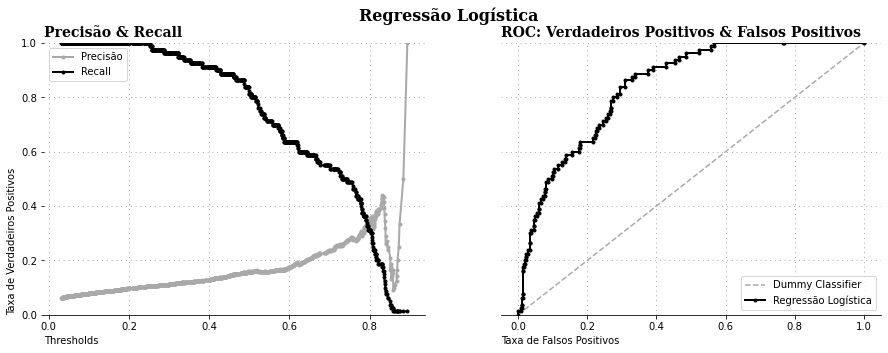

In [146]:
ns_probs = [0 for _ in range(len(y_test_def))]
lr_probs = logreg_pipeline.predict_proba(X_test_def)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test_def, ns_probs)
lr_auc = roc_auc_score(y_test_def, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_def, ns_probs)
lr_fpr, lr_tpr, trash = roc_curve(y_test_def, lr_probs)



y_scores = logreg_pipeline.predict_proba(X_test_def)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test_def, y_scores)



# Plots

fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1,2, wspace=0.2,hspace=0)
ax = gs.subplots()

background_color = "#ffffff"
fig.patch.set_facecolor(background_color) # figure background color
ax[0].set_facecolor(background_color) 
ax[1].set_facecolor(background_color)

ax[0].grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax[1].grid(color='gray', linestyle=':', axis='y',  dashes=(1,5))


ax[0].plot(thresholds, precisions[:-1], marker='.', linewidth=2, label='Precisão',color='#a9a9a9')
ax[0].legend(loc='best')
ax[0].plot(thresholds, recalls[:-1], marker='.', linewidth=2,label='Recall',color='#000000')
ax[0].legend(loc='best')
ax[0].set_ylabel('Taxa de Verdadeiros Positivos',loc='bottom')
ax[0].set_xlabel('Thresholds',loc='left')
#plt.legend(loc='center left')
ax[0].set_ylim([0,1])
ax[0].grid(color='gray', linestyle=':', axis='both', zorder=0,  dashes=(1,5))


# plot the roc curve for the model
ax[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifier',color='#a9a9a9')
ax[1].legend(loc='best')
ax[1].plot(lr_fpr, lr_tpr, marker='.', linewidth=2,label='Regressão Logística',color='#000000')
ax[1].legend(loc='best')
ax[1].set_xlabel('Taxa de Falsos Positivos',loc='left')
ax[1].set_ylabel('')
ax[1].set_ylim([0,1])
ax[1].grid(color='gray', linestyle=':', axis='both', zorder=0,  dashes=(1,5))

for s in ["top","right","left"]:
    ax[0].spines[s].set_visible(False)
    ax[1].spines[s].set_visible(False)


ax[0].set_title('Precisão & Recall',loc='left',fontsize=14,fontfamily='serif',fontweight='bold')
ax[1].set_title('ROC: Verdadeiros Positivos & Falsos Positivos',loc='left',fontsize=14,fontfamily='serif',fontweight='bold')

ax[1].tick_params(axis='y', colors=background_color)
fig.suptitle('Regressão Logística', fontsize=16, fontweight='bold', fontfamily='serif', color="#000000")

plt.show()

#### Área abaixo da curva 

In [147]:
roc_auc_score(y_test_def, logreg_tuned_pred)

0.7597558430717863

### Encontrando o threshold ótimo de acordo com a distancia na curva ROC

In [148]:
pr = np.array([lr_fpr,lr_tpr])
distance = np.sqrt((0-lr_fpr)**2 + (1-lr_tpr)**2)
best_trash = trash[np.argmin(distance)]
best_trash

0.4982426201348311

## Tirando dados inúteis

#### Como sabemos que o modelo ótimo encontrado só não zera as variáveis 'Idade','Hipertensão','Doença cardíaca','Nível médio de glicose', não precisamos das demais no treinamento. Assim, usaremos uma base com somente as variáveis não zeradas pelo modelo

In [149]:
X_empty = df[['Idade','Hipertensão','Doença cardíaca','Nível médio de glicose']].copy()

In [150]:
y_empty = df['Derrame'].copy()

In [151]:
X_train_empty, X_test_empty, y_train_empty, y_test_empty = train_test_split(X_empty, y_empty, test_size=0.25, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_empty, y_train_empty = ros.fit_resample(X_train_empty, y_train_empty)

logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.004772,penalty='l1',
                                                                                        solver= 'liblinear',random_state=42))])
logreg_pipeline.fit(X_train_empty, y_train_empty)
logreg_tuned_pred = logreg_pipeline.predict(X_test_empty)

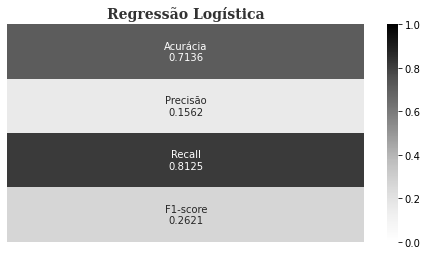

In [152]:
fig = plt.figure(figsize=(8,4))
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.1, hspace=0.25)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#ffffff"
fig.patch.set_facecolor(background_color)

scores_names = np.array(['Acurácia','Precisão',
                     'Recall','F1-score'])

logreg_scores = np.array([accuracy_score(y_test_empty,logreg_tuned_pred),precision_score(y_test_empty,logreg_tuned_pred),
                     recall_score(y_test_empty,logreg_tuned_pred),f1_score(y_test_empty,logreg_tuned_pred)])

group_scores = ['{:.4f}'.format(value) for value in
                logreg_scores]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(scores_names,group_scores)]
labels = np.asarray(labels).reshape(4,1)
logreg_scores = np.asarray(logreg_scores).reshape(4,1)

sns.heatmap(logreg_scores, annot=labels, fmt='', cmap='Greys',ax=ax0,xticklabels=False,yticklabels=False,vmin=0, vmax=1)
ax0.tick_params(left=False, bottom=False)
ax0.set_title('Regressão Logística',loc='center', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

plt.show()

In [153]:
roc_auc_score(y_test_empty, logreg_tuned_pred)

0.7597558430717863